In [119]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [120]:
# import torch
import numpy as np
import pandas as pd

### Load features and labels

In [83]:
# data = np.load("openl3.npy") 
# data = np.load("openl3_48k.npy")
features1 = np.load("resnet.npy") # video
features2 = np.load("yamnet.npy") # audio
# data = np.load("vgg.npy") # video
print(features1.shape, features2.shape)

(25403, 2048) (25403, 2, 1024)


In [ ]:
#use PCA to reduce the dimension. Same size. (512,128)
#try concatenate
#or give different amount of data for each modality.

In [84]:
features2 = features2.reshape(25403, 2*1024)

In [85]:
labels = pd.read_csv("all_labels.csv")
labels.head()

,Unnamed: 0,file_name,timestamp,car,truck,bicycle,motorbike,bus,total,night,snow,rain,has_annotation
0,0,street_traffic-barcelona-161-4901,0.5,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0
1,1,street_traffic-barcelona-161-4901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,2,street_traffic-barcelona-161-4901,1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3,street_traffic-barcelona-161-4901,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,4,street_traffic-barcelona-161-4901,2.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


### Remove all the data that we have not annotated

In [86]:
filtered_features1 = []
filtered_features2 = []

filtered_labels = []

In [87]:
labels[labels["has_annotation"] == 1].shape

(6346, 13)

In [88]:
for idx, row in labels.iterrows():
    if row["has_annotation"] == 1:
        filtered_features1.append(features1[idx])
        filtered_features2.append(features2[idx])
        filtered_labels.append(row)
filtered_labels = pd.DataFrame(filtered_labels).reset_index()
filtered_features1 = np.array(filtered_features1)
filtered_features2 = np.array(filtered_features2)

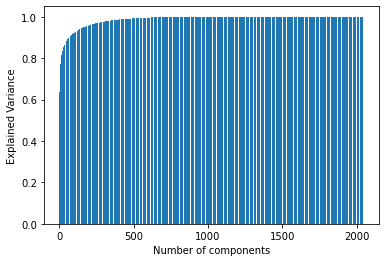

In [89]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
## code here
scaler2 = preprocessing.StandardScaler().fit(filtered_features2)
dataS2=scaler2.transform(filtered_features2)

pca2 = PCA(dataS2.shape[1])
dataP2=pca2.fit_transform(dataS2)
eigenvalues = pca2.explained_variance_ratio_

import matplotlib.pyplot as plt
#Plot explained variance per number of leading PC's 
n=2048
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [90]:
scaler1 = preprocessing.StandardScaler().fit(filtered_features1)
dataS1=scaler1.transform(filtered_features1)

pca1=PCA(n_components=128)
dataP1=pca1.fit_transform(dataS1)

In [91]:
scaler2 = preprocessing.StandardScaler().fit(filtered_features2)
dataS2=scaler2.transform(filtered_features2)

pca2 = PCA(n_components=128)
dataP2=pca2.fit_transform(dataS2)

In [92]:
print(dataP1.shape)
print(dataP2.shape)

(6346, 128)
(6346, 128)


In [93]:
del features1
del features2

In [94]:
del labels

In [95]:
filtered_features1.shape

(6346, 2048)

In [96]:
filtered_features2.shape

(6346, 2048)

In [97]:
filtered_labels.shape

(6346, 14)

## Classify count of all kinds of cars

In [98]:
def get_count_label(num):
    if num == 0:
        return "free"
    if num < 3:
        return "few"
    if num < 6:
        return "medium"
    return "busy"

In [99]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
filtered_labels["total_encoder"] = labelencoder.fit_transform(filtered_labels["total"].apply(get_count_label))

enc = OneHotEncoder(handle_unknown='ignore')
y = enc.fit_transform(filtered_labels[["total_encoder"]]).toarray()

y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [100]:
labelencoder.classes_

array(['busy', 'few', 'free', 'medium'], dtype=object)

### Concatenation of  Features

In [101]:
# concatenation
filtered_features = np.concatenate((dataP1, dataP2), axis=1)

In [102]:
filtered_features.shape

(6346, 256)

In [19]:
## https://www.aclweb.org/anthology/P18-2096.pdf

In [20]:
# from torch import nn

# # define model architecture
# model = nn.Sequential(
#     nn.Linear(4096, 2048),
#     nn.ReLU(),
# )

# # print model architecture
# print(model)

Sequential(
  (0): Linear(in_features=4096, out_features=2048, bias=True)
  (1): ReLU()
)


In [21]:
# from torch import from_numpy
# c_features = model(from_numpy(filtered_features)).detach().numpy()

In [22]:
# c_features

array([[0.        , 0.        , 0.11107685, ..., 0.        , 0.        ,
        0.26001614],
       [0.        , 0.        , 0.1829404 , ..., 0.        , 0.        ,
        0.1749494 ],
       [0.        , 0.        , 0.10042836, ..., 0.02883024, 0.        ,
        0.2789121 ],
       ...,
       [0.15361604, 0.        , 0.4004631 , ..., 0.        , 0.        ,
        0.        ],
       [0.10180113, 0.        , 0.40997142, ..., 0.02845412, 0.        ,
        0.        ],
       [0.14453015, 0.        , 0.43018255, ..., 0.03424089, 0.        ,
        0.00986492]], dtype=float32)

In [103]:
from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(filtered_features, y, test_size=0.2, random_state=42)

In [104]:
# one hot encoding will make random forest results worse
X_train, X_valid, y_train, y_valid = train_test_split(filtered_features, filtered_labels["total_encoder"], test_size=0.2, random_state=42)

In [ ]:
def evaluate_svm(model, test_features, test_labels, labels):
    accuracy = model.score(test_features, test_labels)
    print("accuracy:", accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, test_features, test_labels,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.decision_function(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()
    
    print(classification_report(test_labels, model.predict(test_features)))

    return accuracy

In [ ]:
from sklearn.svm import SVC

acc = {}
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]

for num in numOfSamples:
    print("training samples from video: ", num)
    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], features2), axis=0)
        y_combine_train = np.concatenate((y_train[:num],labels["total_encoder"]), axis=0)
    else:
        X_combine_train = features2
        y_combine_train = labels["total_encoder"]

    clf = SVC(kernel="linear", decision_function_shape="ovo", random_state=42)
    clf.fit(X_combine_train, y_combine_train)
    random_accuracy = evaluate_svm(clf, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy

### Random Forest

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [106]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 40)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [107]:
random_forest_clf = RandomForestClassifier(random_state=42)

In [108]:
rf_random = RandomizedSearchCV(estimator = random_forest_clf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 12, 14, 16, 19, 21,
                                                      23, 26, 28, 30, 33, 35,
                                                      37, 40, 42, 44, 46, 49,
                                                      51, 53, 56, 58, 60, 63,
                                                      65, 67, 70, 72, 74, 76, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                 

In [109]:
filtered_features.shape

(6346, 256)

In [110]:
X_train.shape

(5076, 256)

In [112]:
#generate a dataframe which contains all results
df_ytrain=pd.DataFrame(y_train)
df_ytrain=df_ytrain.reset_index()
train_predict=pd.DataFrame(rf_random.predict(X_train))
encoder_train=pd.merge(df_ytrain,train_predict,left_index=True, right_index=True).set_index('index')

df_yvalid=pd.DataFrame(y_valid).reset_index()
valid_predict=pd.DataFrame(rf_random.predict(X_valid))
encoder_valid=pd.merge(df_yvalid,valid_predict,left_index=True, right_index=True).set_index('index')

allpred_encoder=pd.concat([encoder_train,encoder_valid],axis=0)
new_col = ['total_encoder', 'pred_encoder']
allpred_encoder.columns = new_col
allpred_encoder=allpred_encoder.sort_index(ascending=True)
pred_flabels=pd.merge(filtered_labels,allpred_encoder['pred_encoder'],left_index=True, right_index=True)

pred_flabels['result'] = np.where(pred_flabels['total_encoder']==pred_flabels['pred_encoder'],'True','False')
pred_flabels

,index,Unnamed: 0,file_name,timestamp,car,truck,bicycle,motorbike,bus,total,night,snow,rain,has_annotation,total_encoder,pred_encoder,result
0,0,0,street_traffic-barcelona-161-4901,0.5,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1,1,True
1,1,1,street_traffic-barcelona-161-4901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
2,2,2,street_traffic-barcelona-161-4901,1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
3,3,3,street_traffic-barcelona-161-4901,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
4,4,4,street_traffic-barcelona-161-4901,2.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,14340,14340,street_traffic-milan-1094-42024,7.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True
6342,14341,14341,street_traffic-milan-1094-42024,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True
6343,14342,14342,street_traffic-milan-1094-42024,8.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True
6344,14343,14343,street_traffic-milan-1094-42024,9.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True


In [113]:
#calculate only valid data accuracy
pred_encoder=encoder_valid
new_col = ['total_encoder', 'pred_encoder']
pred_encoder.columns = new_col
pred_encoder['result'] = np.where(pred_encoder['total_encoder']==pred_encoder['pred_encoder'],'True','False')
pred_encoder

,total_encoder,pred_encoder,result
index,,,
730,0,1,False
5641,1,1,True
5635,1,1,True
4280,1,1,True
217,3,3,True
...,...,...,...
2187,1,1,True
2389,2,1,False
2893,1,1,True


<AxesSubplot:>

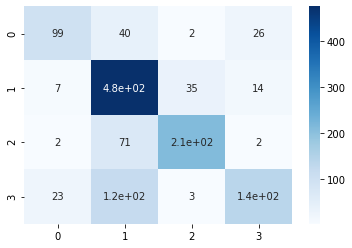

In [114]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_encoder['total_encoder'], pred_encoder['pred_encoder'])

##'busy', 'few', 'free', 'medium'
import seaborn as sn
df_cm = pd.DataFrame(cm) 
sn.heatmap(df_cm,cmap='Blues',annot=True)

In [115]:
#use same random state to get the valid results
valid_pred=pred_flabels.sample(n=1270,random_state=42)

#Day
dayt=valid_pred[(valid_pred['night']==0)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['night']==0)].shape[0]
#Night
dayf=valid_pred[(valid_pred['night']==1)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['night']==1)].shape[0]
#No Snow
snowf=valid_pred[(valid_pred['snow']==0)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['snow']==0)].shape[0]
#Snow
snowt=valid_pred[(valid_pred['snow']==1)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['snow']==1)].shape[0]
#No Rain
rainf=valid_pred[(valid_pred['rain']==0)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['rain']==0)].shape[0]
#Rain
raint=valid_pred[(valid_pred['rain']==1)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['rain']==1)].shape[0]

In [118]:
[dayt,raint,snowt], [dayf,rainf,snowf]

([0.740301724137931, 0.2222222222222222, 0.7786259541984732],
 [0.6900584795321637, 0.7303727200634417, 0.7208077260755048])

In [116]:
import plotly.graph_objs as go
import plotly.offline as py
trace0 = go.Bar(
    x = ['Day','Rain','Snow'],
    y = [dayt,raint,snowt],
    name = 'True',
    marker=dict(
        color = 'rgb(49,130,189)'
    )
)
trace1 = go.Bar(
    x = ['Day','Rain','Snow'],
    y = [dayf,rainf,snowf],
    name = 'False',
    marker=dict(
        color = 'rgb(204,204,204)'
    )
)
data = [trace0,trace1]
py.iplot(data)

In [117]:
rf_random.best_params_

{'n_estimators': 1927,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 70}

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

def evaluate(model, test_features, test_labels, labels):
    print("accuracy:", model.score(test_features, test_labels))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, X_valid, y_valid,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.predict_proba(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()

    return model.score(test_features, test_labels)



accuracy: 0.6488188976377953
[[0.56886228 0.22155689 0.02994012 0.17964072]
 [0.03389831 0.78719397 0.09981168 0.07909605]
 [0.01045296 0.29268293 0.67944251 0.0174216 ]
 [0.10175439 0.48070175 0.01052632 0.40701754]]


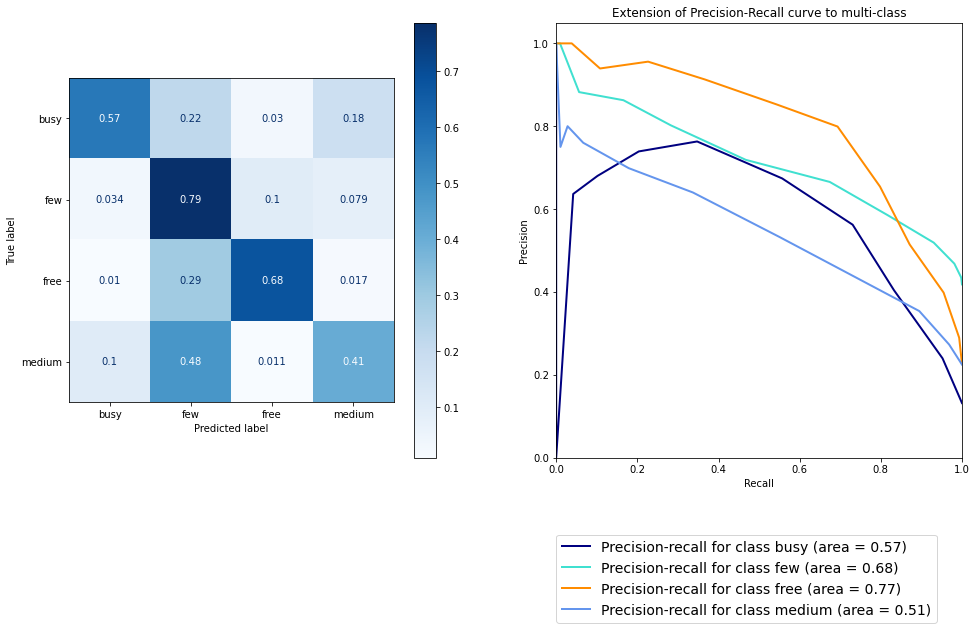

In [39]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_valid, y_valid, labelencoder.classes_)

In [ ]:
#get a page of results, save the numbers

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, best_random.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66       167
           1       0.67      0.90      0.77       531
           2       0.84      0.75      0.79       287
           3       0.78      0.47      0.59       285

    accuracy                           0.73      1270
   macro avg       0.76      0.68      0.70      1270
weighted avg       0.75      0.73      0.72      1270



accuracy: 0.7291338582677165
[[0.58682635 0.25149701 0.01197605 0.1497006 ]
 [0.01318267 0.90018832 0.06779661 0.01883239]
 [0.00696864 0.2369338  0.74912892 0.00696864]
 [0.08070175 0.43508772 0.01052632 0.47368421]]


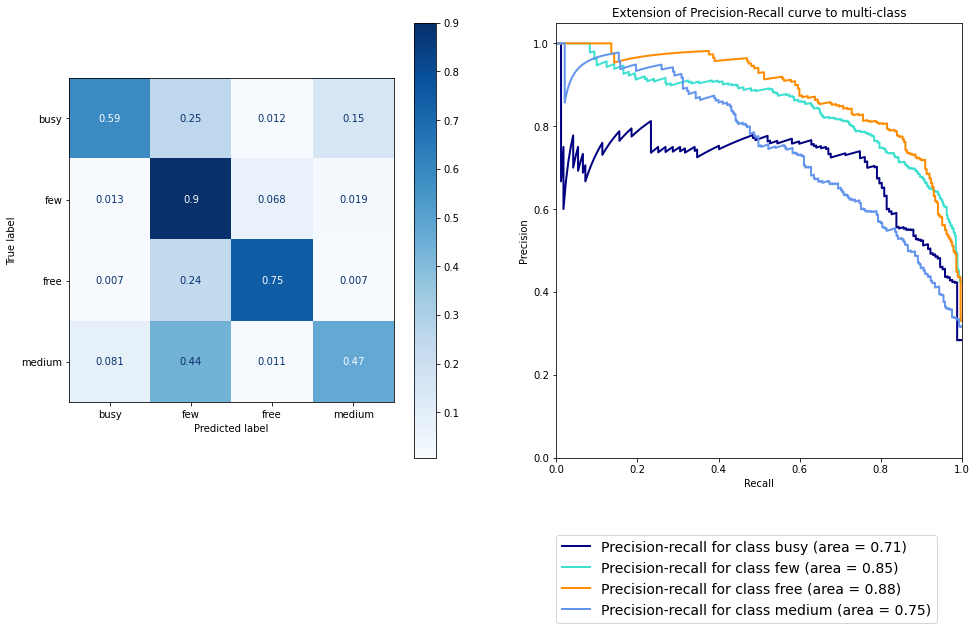

In [40]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valid, y_valid, labelencoder.classes_)

#### Test concatenation with different weight

accuracy: 0.6716535433070866
[[0.56886228 0.22155689 0.01197605 0.19760479]
 [0.0433145  0.79661017 0.09039548 0.06967985]
 [0.02787456 0.24390244 0.71080139 0.0174216 ]
 [0.11578947 0.4        0.0245614  0.45964912]]


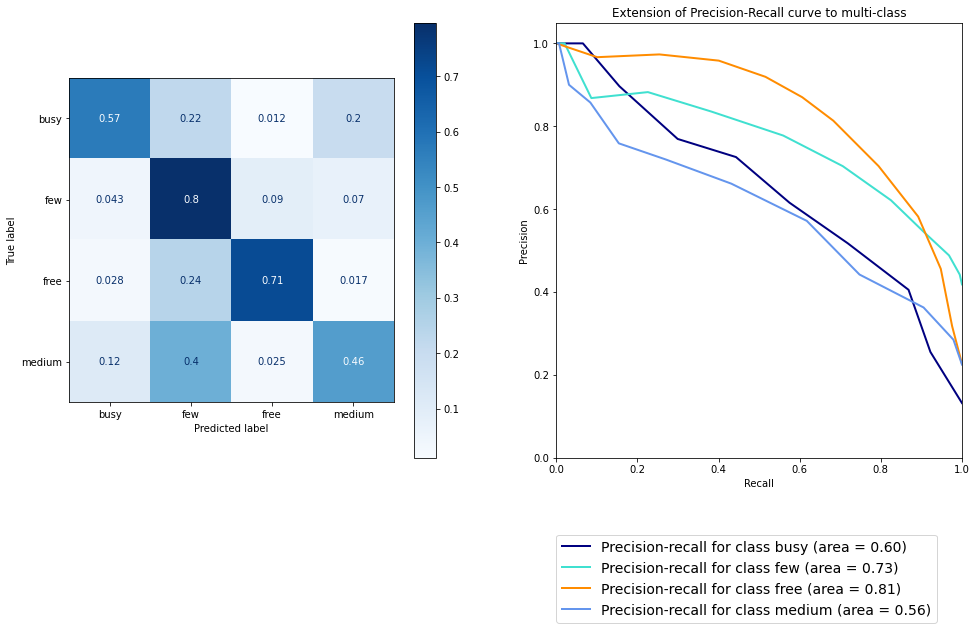

accuracy: 0.6716535433070866
[[0.56886228 0.22155689 0.01197605 0.19760479]
 [0.0433145  0.79661017 0.09039548 0.06967985]
 [0.02787456 0.24390244 0.71080139 0.0174216 ]
 [0.11578947 0.4        0.0245614  0.45964912]]


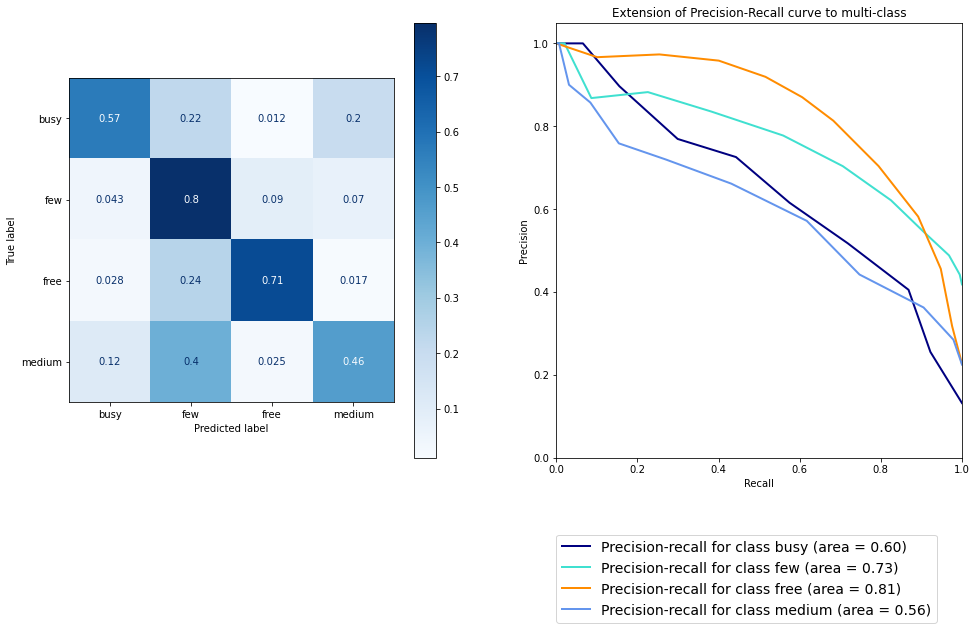

accuracy: 0.6716535433070866
[[0.56886228 0.22155689 0.01197605 0.19760479]
 [0.0433145  0.79661017 0.09039548 0.06967985]
 [0.02787456 0.24390244 0.71080139 0.0174216 ]
 [0.11578947 0.4        0.0245614  0.45964912]]


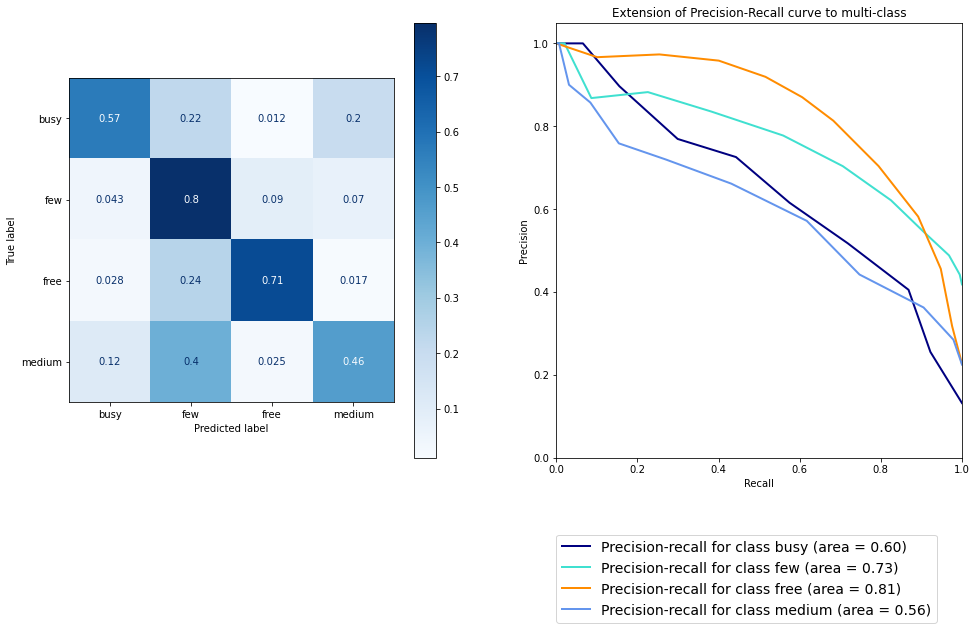

accuracy: 0.6716535433070866
[[0.56886228 0.22155689 0.01197605 0.19760479]
 [0.0433145  0.79661017 0.09039548 0.06967985]
 [0.02787456 0.24390244 0.71080139 0.0174216 ]
 [0.11578947 0.4        0.0245614  0.45964912]]


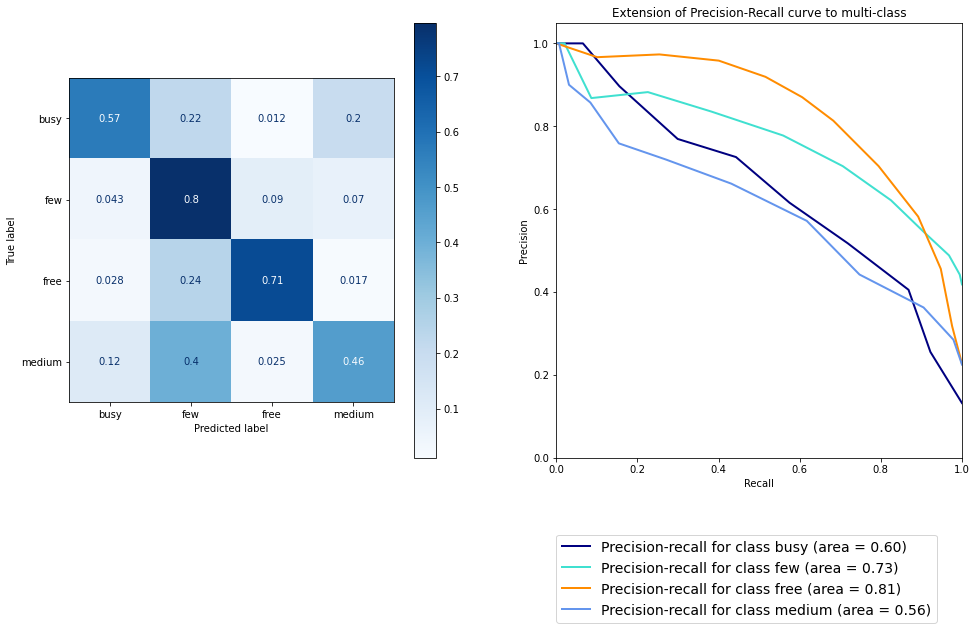

In [57]:
for w1 in [0.6, 0.7, 0.8, 0.9]:
    w2 = 1 - w1
    filtered_features = np.concatenate((filtered_features1*w1, filtered_features2*w2), axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(filtered_features, filtered_labels["total_encoder"], test_size=0.2, random_state=42)
    
    base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_valid, y_valid, labelencoder.classes_)

### SVM

In [58]:
def evaluate_svm(model, test_features, test_labels, labels):
    print("accuracy:", model.score(test_features, test_labels))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, X_valid, y_valid,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.decision_function(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()

    return model.score(test_features, test_labels)

#### Test concatenation with different weight

In [ ]:
#reduce audio&video to same dimension or different.
#audio, video, audio...
#try by classes

In [59]:
from sklearn.svm import SVC

for w1 in [0.6, 0.7, 0.8, 0.9]:
    w2 = 1 - w1
    filtered_features = np.concatenate((filtered_features1*w1, filtered_features2*w2), axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(filtered_features, filtered_labels["total_encoder"], test_size=0.2, random_state=42)
    
    clf = SVC(kernel="linear", decision_function_shape="ovo")
    clf.fit(X_train, y_train)
    print("w1: ", w1, "accuracy: ", clf.score(X_valid, y_valid))

w1:  0.6 accuracy:  0.7464566929133858
w1:  0.7 accuracy:  0.7559055118110236
w1:  0.8 accuracy:  0.7566929133858268
w1:  0.9 accuracy:  0.7535433070866142


linear
accuracy: 0.7566929133858268
[[0.79041916 0.07185629 0.         0.13772455]
 [0.03201507 0.77589454 0.10357815 0.08851224]
 [0.00348432 0.14285714 0.8466899  0.00696864]
 [0.12982456 0.24561404 0.01403509 0.61052632]]


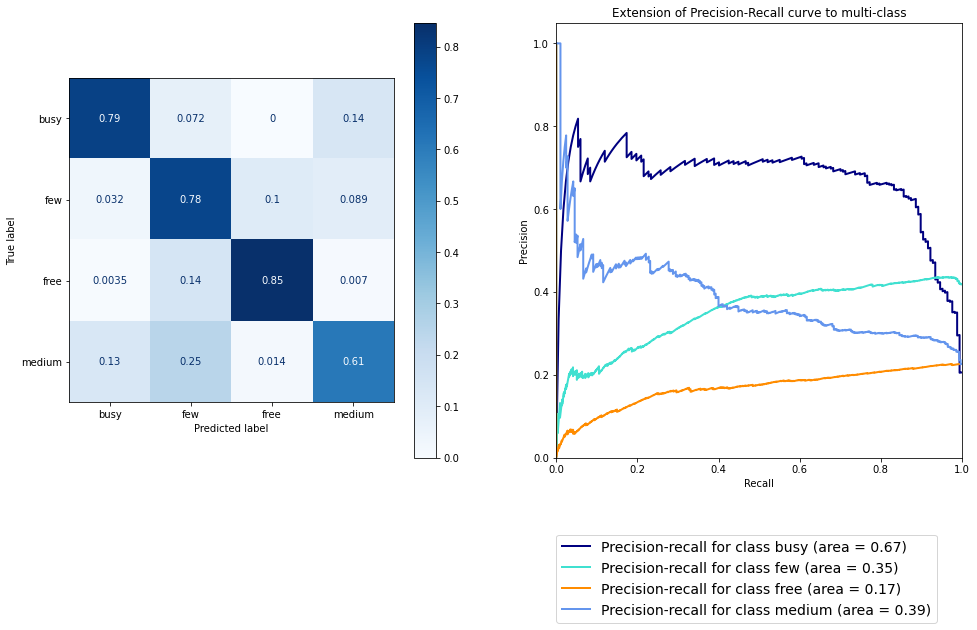

poly
accuracy: 0.6354330708661418
[[0.54491018 0.26946108 0.         0.18562874]
 [0.04519774 0.74199623 0.0960452  0.11676083]
 [0.02439024 0.28919861 0.6445993  0.04181185]
 [0.09473684 0.41403509 0.01052632 0.48070175]]


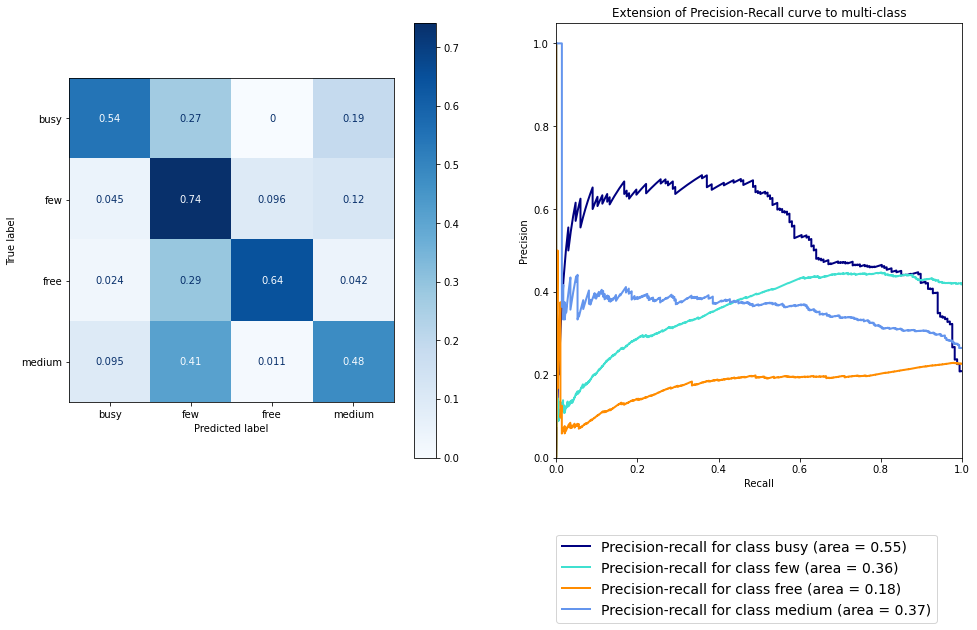

rbf
accuracy: 0.5976377952755906
[[0.48502994 0.34131737 0.00598802 0.16766467]
 [0.05649718 0.74764595 0.086629   0.10922787]
 [0.03484321 0.36585366 0.56097561 0.03832753]
 [0.10526316 0.45614035 0.01754386 0.42105263]]


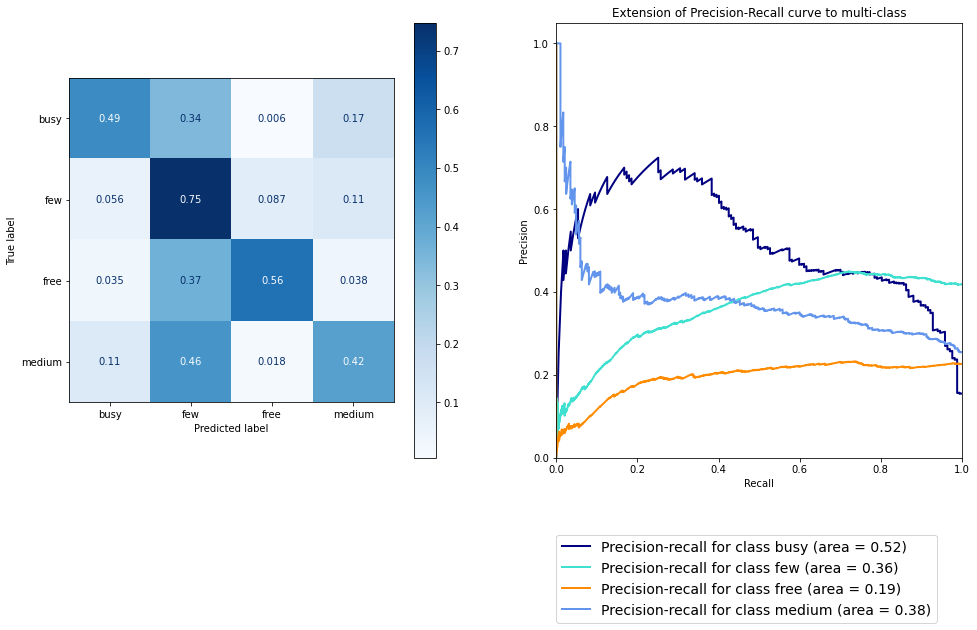

sigmoid
accuracy: 0.49133858267716535
[[0.37724551 0.54491018 0.         0.07784431]
 [0.05461394 0.77777778 0.13747646 0.03013183]
 [0.03135889 0.5261324  0.42160279 0.02090592]
 [0.0877193  0.74385965 0.07368421 0.09473684]]


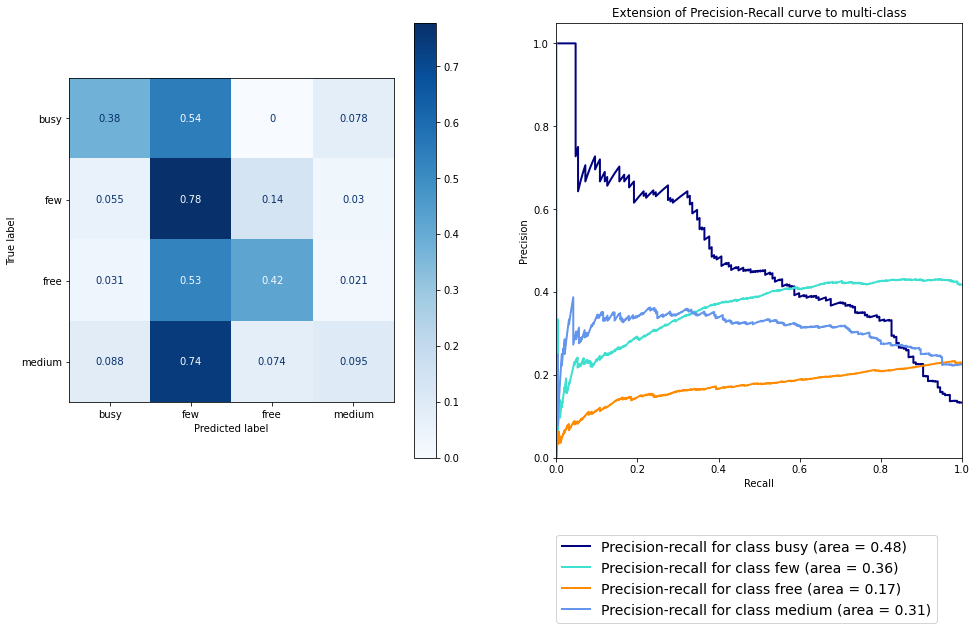

In [60]:
filtered_features = np.concatenate((filtered_features1*0.8, filtered_features2*0.2), axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(filtered_features, filtered_labels["total_encoder"], test_size=0.2, random_state=42)
    

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    print(kernel)
    clf = SVC(kernel=kernel, decision_function_shape="ovo", random_state=42)
    clf.fit(X_train, y_train)
    random_accuracy = evaluate_svm(clf, X_valid, y_valid, labelencoder.classes_)

### LSTM

In [61]:
filtered_features = np.concatenate((filtered_features1, filtered_features2), axis=1)

In [62]:
filtered_features = filtered_features.reshape(6346//19, 19, 4096)

In [63]:
filtered_features.shape

(334, 19, 4096)

In [71]:
video_labels = pd.read_csv("video_labels.csv")
video_labels = video_labels[video_labels["has_annotation"]==1]

In [72]:
labelencoder = LabelEncoder()
video_labels["count_label"] = labelencoder.fit_transform(video_labels["total"].apply(get_count_label))

In [73]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(video_labels["count_label"])

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(filtered_features, y, test_size=0.2, random_state=42)

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [76]:
verbose, epochs, batch_size = 0, 50, 30
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_valid, y_valid, batch_size=batch_size, verbose=0)
print(accuracy)

0.5522388


In [77]:
_, insample_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
print(insample_accuracy)

0.92134833
